# Generating Multiple Images

### Check GPU

In [1]:
!nvidia-smi
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Mon Sep 11 05:30:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10G                    On  | 00000000:00:1E.0 Off |                    0 |
|  0%   38C    P0              43W / 300W |      2MiB / 23028MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install Requirements

In [2]:
!pip install -q --upgrade accelerate transformers ftfy
!pip install -q git+https://github.com/huggingface/diffusers


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!wget https://rhods-public.s3.amazonaws.com/src/xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl -O xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl
!pip install -q xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl

--2023-09-11 05:30:24--  https://rhods-public.s3.amazonaws.com/src/xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl
Resolving rhods-public.s3.amazonaws.com (rhods-public.s3.amazonaws.com)... 52.217.126.193, 52.216.51.193, 52.217.44.212, ...
Connecting to rhods-public.s3.amazonaws.com (rhods-public.s3.amazonaws.com)|52.217.126.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127729734 (122M) [binary/octet-stream]
Saving to: ‘xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl’

xformers-0.0.21.dev 100%[===================>] 121.81M  55.1MB/s    in 2.2s    

2023-09-11 05:30:27 (55.1 MB/s) - ‘xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl’ saved [127729734/127729734]


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip list | grep -e torch -e torchvision -e diffusers -e accelerate -e torchvision -e transformers -e ftfy -e tensorboard -e Jinja2 -e xformers -e protobuf


accelerate                      0.22.0
diffusers                       0.21.0.dev0
ftfy                            6.1.1
Jinja2                          3.1.2
protobuf                        3.20.3
tensorboard                     2.11.2
tensorboard-data-server         0.6.1
tensorboard-plugin-wit          1.8.1
torch                           1.13.1
torchvision                     0.14.1
transformers                    4.33.1
xformers                        0.0.21.dev584

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Settings

In [5]:
import os
from datetime import datetime

VERSION = os.environ.get("VERSION", f"notebook-output")

# MODEL_ID = "stabilityai/stable-diffusion-2-1-base"
MODEL_ID = os.path.join(os.getcwd(), f"{VERSION}/stable_diffusion_weights/wright-flyer")

print(f"Weights loaded from be saved at {MODEL_ID}")


Weights loaded from be saved at /opt/app-root/src/shgriffi-demo/notebook-output/stable_diffusion_weights/wright-flyer


## Test Inference

In [6]:
import torch
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(MODEL_ID)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline.to(device)
pipeline.enable_xformers_memory_efficient_attention()


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
from datetime import datetime
from torch import autocast

prompt = "photo of a small awrtflyr airplane parked on a grassy field in front of a museum"
negative_prompt = ""
num_samples = 6
guidance_scale = 7.5
num_inference_steps = 50
height = 512
width = 512

generator = torch.Generator(device=device)
generator.seed()

with autocast(device.type), torch.inference_mode():
    images = pipeline(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator
    ).images


date = datetime.now()
date_string = date.strftime('%Y%m%d%H%M%S')
IMG_DIR =  os.path.join(os.getcwd(), f"{VERSION}/generated-images/{date_string}")
os.makedirs(IMG_DIR, exist_ok=True)

for i, img in enumerate(images):
    img.save(os.path.join(IMG_DIR, f"{i}.jpg"))


  0%|          | 0/50 [00:00<?, ?it/s]

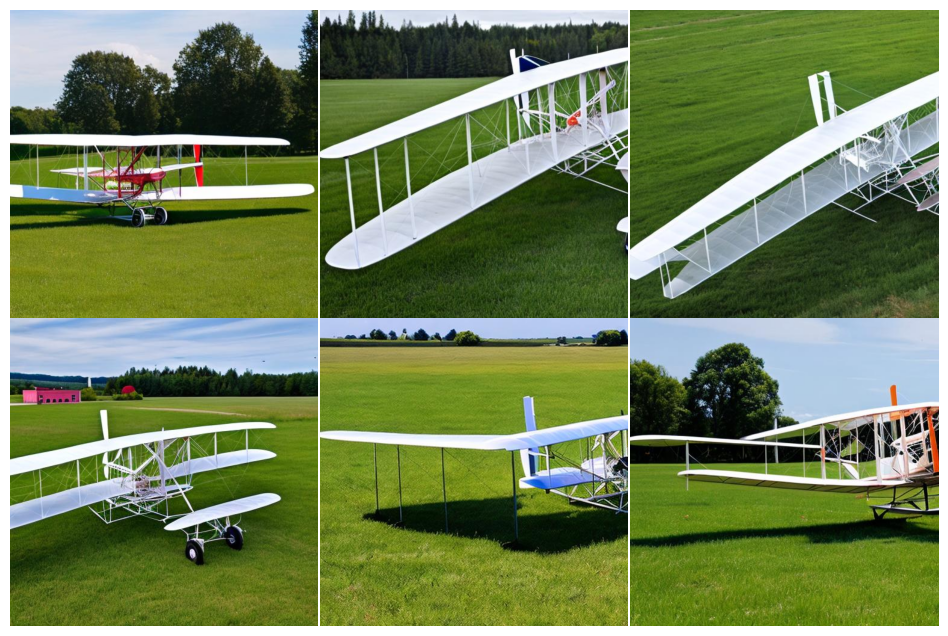

In [8]:
import os
import math
import matplotlib.pyplot as plt
from PIL import Image

directory = IMG_DIR
images = []
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):
        img = Image.open(os.path.join(directory, filename))
        images.append(img)

num_show = min(len(images), 12)
n_cols = 3
n_rows = math.ceil(len(images) / n_cols)
scale = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * scale, n_rows * scale),  gridspec_kw={'hspace': 0, 'wspace': 0})
for i in range(n_rows):
    for j in range(n_cols):
        axs[i, j].axis('off')
        x = i * n_cols + j
        if x < len(images):
            axs[i, j].imshow(images[x])
plt.show()
